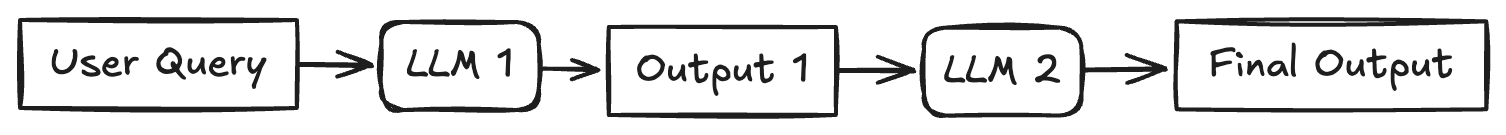

Use Cases:

* Generating a structured document: LLM 1 creates an outline, LLM 2 validates the outline against criteria, LLM 3 writes the content based on the validated outline.

* Multi-step data processing: Extracting information, transforming it, and then summarizing it.

* Generating newsletters based on curated inputs.

source: https://www.philschmid.de/agentic-pattern

In [ ]:
# ============================================================================
# SETUP: Import Dependencies
# ============================================================================
# This cell initializes all necessary libraries and connects to OpenAI API.
# We use Pydantic for type validation and structured output parsing.

import json
import sys
from pathlib import Path
from openai import OpenAI
from pydantic import BaseModel, Field
from typing import List
from src.fnHelpers import pydantic_to_openai_schema

# Initialize OpenAI client (requires OPENAI_API_KEY environment variable)
client = OpenAI()

In [ ]:
# ============================================================================
# HELPER FUNCTION: generate_json()
# ============================================================================
# This function encapsulates the OpenAI API call with JSON schema enforcement.
# It ensures that OpenAI returns structured, type-safe JSON matching our Pydantic models.
#
# Why use structured outputs?
# - Guarantees the LLM output matches our expected schema
# - Eliminates parsing errors and hallucinations
# - Type-safe: we can use the response immediately without error handling

def generate_json(prompt: str, schema: dict, model_name: str = "gpt-4o-mini", temperature: float = 0.0):
    """
    Call OpenAI API with JSON schema enforcement.
    
    Args:
        prompt: The user message to send to the LLM
        schema: Pydantic schema in OpenAI format (from pydantic_to_openai_schema)
        model_name: Which OpenAI model to use (default: gpt-4o-mini)
        temperature: Randomness level 0.0-1.0 (0=deterministic, 1=creative)
    
    Returns:
        Parsed JSON dict matching the provided schema
    """
    response = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        response_format={"type": "json_schema", "json_schema": schema},
    )
    return json.loads(response.choices[0].message.content)

# Step 1: Topic Ideation and Keyword Generation

In [ ]:
# ============================================================================
# STEP 1: Define Data Models for Topic Generation
# ============================================================================
# These Pydantic models define the expected structure for blog post data.
# Each Field() call includes a description that helps the LLM understand what's expected.

class BlogPost(BaseModel):
    """Single blog post with title and SEO keywords."""
    blog_title: str = Field(description="Engaging blog post title")
    seo_keywords: List[str] = Field(description="List of 10 relevant SEO keywords")

class BlogPostList(BaseModel):
    """Wrapper for array of blog posts (required by OpenAI strict schema)."""
    items: List[BlogPost] = Field(description="Array of blog post objects")

In [4]:
# ============================================================================
# AGENT 1: Blog Post Title & SEO Keyword Generation
# ============================================================================
# Prompt the LLM to generate 5 blog post titles and SEO keywords for a topic.
# This is the first step in the multi-agent workflow.

topic = "The benefits of intermittent fasting for beginners"

prompt1 = (
    f"Generate 5 engaging blog post titles and a list of 10 relevant SEO keywords for the topic: {topic}. "
    "Return a strict JSON object with key 'items' as an array of objects with keys 'blog_title' and 'seo_keywords' (array of strings)."
)

# Convert Pydantic model to OpenAI-compatible schema with strict validation
blogpost_array_schema = pydantic_to_openai_schema(BlogPostList, "blogpost_array")

# Call the LLM and parse the structured response
raw_posts = generate_json(prompt1, schema=blogpost_array_schema, model_name="gpt-4o-mini", temperature=0)

# Convert raw JSON to Pydantic objects for type safety
blog_posts: list[BlogPost] = [BlogPost(**item) for item in raw_posts["items"]]

# Display the generated blog posts
blog_posts

[BlogPost(blog_title="Unlocking the Power of Intermittent Fasting: A Beginner's Guide", seo_keywords=['intermittent fasting', 'benefits of fasting', "beginner's guide", 'weight loss', 'health benefits', 'fasting schedule', 'metabolism boost', 'improve focus', 'digestive health', 'lifestyle change']),
 BlogPost(blog_title='Intermittent Fasting 101: Why You Should Start Today', seo_keywords=['intermittent fasting', 'fasting benefits', 'health tips', 'beginner fasting', 'weight management', 'energy levels', 'mental clarity', 'eating windows', 'meal planning', 'healthy lifestyle']),
 BlogPost(blog_title="The Ultimate Beginner's Guide to Intermittent Fasting: Transform Your Health", seo_keywords=['intermittent fasting', 'health transformation', 'beginner tips', 'fasting methods', 'caloric intake', 'body detox', 'improve health', 'sustainable weight loss', 'fasting for beginners', 'wellness journey']),
 BlogPost(blog_title='Intermittent Fasting for Beginners: How to Get Started and Thrive', 

In [ ]:
# ============================================================================
# SELECT ONE: Randomly Choose a Blog Post
# ============================================================================
# In a real workflow, we might apply validation or ranking.
# For this demo, we randomly select one of the generated titles.

import random
chosen_blog_post = random.choice(blog_posts)

In [32]:
# Display the randomly selected blog post
chosen_blog_post

BlogPost(blog_title='Intermittent Fasting 101: Why You Should Start Today', seo_keywords=['intermittent fasting', 'fasting benefits', 'health tips', 'beginner fasting', 'weight management', 'energy levels', 'mental clarity', 'eating windows', 'meal planning', 'healthy lifestyle'])

In [ ]:
# ============================================================================
# EXTRACT: Parse Selected Blog Post Details
# ============================================================================
# Extract the title and keywords to use in downstream prompts.

chosen_title = chosen_blog_post.blog_title
chosen_keywords = chosen_blog_post.seo_keywords

In [34]:
# ============================================================================
# STATUS: Print the Selected Blog Post
# ============================================================================
print(f"✅ Randomly selected blog post: '{chosen_title}'")
print("-" * 100)

✅ Randomly selected blog post: 'Intermittent Fasting 101: Why You Should Start Today'
----------------------------------------------------------------------------------------------------


# Step 2: Outline Creation

In [ ]:
# ============================================================================
# STEP 2: Define Data Models for Blog Outline
# ============================================================================
# These models structure the outline that Agent 2 will generate.
# A good outline includes intro, organized sections with subheadings, and conclusion.

class BlogSection(BaseModel):
    """Represents one section of the blog post."""
    section_title: str = Field(description="The main heading for this section.")
    subheadings: List[str] = Field(description="A list of sub-points or subheadings within this section.")

class BlogOutline(BaseModel):
    """Complete blog post outline structure."""
    introduction: str = Field(description="A brief paragraph summarizing the introduction.")
    main_sections: List[BlogSection] = Field(description="A list of the main sections of the blog post.")
    conclusion: str = Field(description="A brief paragraph summarizing the conclusion.")

In [ ]:
# ============================================================================
# AGENT 2: Blog Post Outline Generation
# ============================================================================
# Build a detailed outline using the selected title and keywords.
# We use f-strings to inject the title and keywords into the prompt.

prompt2 = f"""
Based on the following blog post title and SEO keywords, create a detailed blog post outline.

Blog Title: "{chosen_title}"

SEO Keywords: {', '.join(chosen_keywords)}

The outline should have a clear introduction, several main sections with relevant subheadings, and a concluding summary.
"""

In [37]:
# ============================================================================
# CALL AGENT 2: Generate Outline
# ============================================================================
# Convert the BlogOutline model to OpenAI schema and call the LLM.
# Temperature=0 ensures deterministic, consistent output.

blog_outline_schema = pydantic_to_openai_schema(BlogOutline, "blog_outline")

response2_json = generate_json(
    prompt2,
    schema=blog_outline_schema,
    model_name="gpt-4o",  # Using gpt-4o for better outline quality
    temperature=0  # Deterministic: same input always gives same output
)

# Print the raw JSON response for transparency
print(response2_json)

{'introduction': 'Intermittent fasting has gained popularity as a powerful tool for improving health and managing weight. This guide will explore the basics of intermittent fasting, its benefits, and how you can start incorporating it into your lifestyle today.', 'main_sections': [{'section_title': 'Understanding Intermittent Fasting', 'subheadings': ['What is Intermittent Fasting?', 'Different Types of Fasting Methods', 'The Science Behind Fasting']}, {'section_title': 'The Benefits of Intermittent Fasting', 'subheadings': ['Weight Management and Fat Loss', 'Boosting Energy Levels', 'Enhancing Mental Clarity', 'Improving Metabolic Health']}, {'section_title': 'Getting Started with Intermittent Fasting', 'subheadings': ['Choosing the Right Fasting Method for Beginners', 'Setting Your Eating Windows', 'Meal Planning for Success', 'Tips for Staying Consistent']}, {'section_title': 'Intermittent Fasting and a Healthy Lifestyle', 'subheadings': ['Combining Fasting with Exercise', 'Balancin

In [38]:
# ============================================================================
# PARSE & DISPLAY: Blog Outline
# ============================================================================
# Convert raw JSON to Pydantic model and display in readable format.

blog_outline: BlogOutline = BlogOutline(**response2_json)
print("\n### Blog Post Outline ###\n")

print(f"Introduction:\n- {blog_outline.introduction}\n")

print("Main Sections:")
for section in blog_outline.main_sections:
    print(f"\n  - {section.section_title}")
    for subheading in section.subheadings:
        print(f"    - {subheading}")

print(f"\nConclusion:\n- {blog_outline.conclusion}")


### Blog Post Outline ###

Introduction:
- Intermittent fasting has gained popularity as a powerful tool for improving health and managing weight. This guide will explore the basics of intermittent fasting, its benefits, and how you can start incorporating it into your lifestyle today.

Main Sections:

  - Understanding Intermittent Fasting
    - What is Intermittent Fasting?
    - Different Types of Fasting Methods
    - The Science Behind Fasting

  - The Benefits of Intermittent Fasting
    - Weight Management and Fat Loss
    - Boosting Energy Levels
    - Enhancing Mental Clarity
    - Improving Metabolic Health

  - Getting Started with Intermittent Fasting
    - Choosing the Right Fasting Method for Beginners
    - Setting Your Eating Windows
    - Meal Planning for Success
    - Tips for Staying Consistent

  - Intermittent Fasting and a Healthy Lifestyle
    - Combining Fasting with Exercise
    - Balancing Nutrition and Fasting
    - Listening to Your Body's Needs

  - Commo

# Step 3: Content Drafting for Each Section
The generated outline is then used to prompt a third AI agent to write the content for each section individually. This ensures that each part of the blog post is detailed and stays on topic.

Prompt 3 (Input): "Write the 'Introduction' section based on the provided outline, making it engaging and clearly stating what the reader will learn." (This is repeated for each section of the outline).

Prompt 3 (Output): The drafted content for a specific section.

In [39]:
# ============================================================================
# STEP 3: Define Data Models for Section Content
# ============================================================================
# Model for individual section content that Agent 3 will write.

import time

class SectionContent(BaseModel):
    """Represents the written content for a single section of the blog post."""
    content: str = Field(description="The fully written text for the blog post section, formatted in Markdown.")

# ============================================================================
# AGENT 3: Multi-step Content Generation Loop
# ============================================================================
# For each section in the outline, prompt the LLM to write detailed content.
# This ensures focused, on-topic writing for each part.

section_schema = pydantic_to_openai_schema(SectionContent, "section_content")

# Initialize the blog post with title and introduction
full_blog_post = []
final_title = chosen_blog_post.blog_title

print(f"✅ Generating content for blog post: '{final_title}'")
print("-" * 50)

# Add the introduction from the outline
full_blog_post.append(f"# {final_title}\n")
full_blog_post.append(f"## Introduction\n\n{blog_outline.introduction}\n")

# Loop through each section and generate detailed content
for section in blog_outline.main_sections:
    print(f"▶️  Generating content for section: '{section.section_title}'...")

    # Craft a specific prompt for this section
    prompt3 = f"""
    You are a helpful content writer. Your task is to write a detailed and engaging section for a blog post titled "{final_title}".

    Write the content for the following section:
    Section Title: "{section.section_title}"

    This section should cover these key points:
    - {', '.join(section.subheadings)}

    Write the content in a clear and informative tone suitable for beginners. Use Markdown for formatting if necessary (e.g., bolding, bullet points). Do not write the section title itself, only the body content.
    """

    # Generate content for this section
    raw3 = generate_json(
        prompt3,
        schema=section_schema,
        model_name="gpt-4o-mini",  # gpt-4o-mini is faster and sufficient for content writing
        temperature=0.3  # Slight creativity for engaging writing
    )
    section_content: SectionContent = SectionContent(**raw3)

    # Append the formatted section to the blog post
    full_blog_post.append(f"## {section.section_title}\n\n{section_content.content}\n")
    
    # Rate limiting: avoid hitting API too quickly
    time.sleep(1)

# Add conclusion
full_blog_post.append(f"## Conclusion\n\n{blog_outline.conclusion}\n")

print("✅ Blog post generation complete!")
print("-" * 50)

# Assemble the final article as a single string
final_article = "\n".join(full_blog_post)

✅ Generating content for blog post: 'Intermittent Fasting 101: Why You Should Start Today'
--------------------------------------------------
▶️  Generating content for section: 'Understanding Intermittent Fasting'...
▶️  Generating content for section: 'The Benefits of Intermittent Fasting'...
▶️  Generating content for section: 'Getting Started with Intermittent Fasting'...
▶️  Generating content for section: 'Intermittent Fasting and a Healthy Lifestyle'...
▶️  Generating content for section: 'Common Challenges and How to Overcome Them'...
✅ Blog post generation complete!
--------------------------------------------------


In [40]:
# ============================================================================
# DISPLAY: Render Blog Post in Markdown Format
# ============================================================================
# IPython's Markdown renderer formats the text beautifully in the notebook.

from IPython.display import Markdown
Markdown(final_article)

# Intermittent Fasting 101: Why You Should Start Today

## Introduction

Intermittent fasting has gained popularity as a powerful tool for improving health and managing weight. This guide will explore the basics of intermittent fasting, its benefits, and how you can start incorporating it into your lifestyle today.

## Understanding Intermittent Fasting

Intermittent fasting (IF) is not just a diet; it’s an eating pattern that alternates between periods of eating and fasting. Unlike traditional diets that focus on what to eat, intermittent fasting emphasizes when to eat. This approach has gained popularity for its simplicity and effectiveness in promoting weight loss and improving overall health.

### What is Intermittent Fasting?

At its core, intermittent fasting involves cycling between periods of eating and fasting. During the fasting phase, you either abstain from food entirely or significantly reduce your calorie intake. This method allows your body to enter a state where it can burn fat more efficiently and improve metabolic health. 

### Different Types of Fasting Methods

There are several popular methods of intermittent fasting, each with its own unique structure. Here are a few of the most common:

- **16/8 Method**: This is one of the most popular methods, where you fast for 16 hours each day and eat during an 8-hour window. For example, you might eat between noon and 8 PM, skipping breakfast.
- **5:2 Diet**: In this method, you eat normally for five days of the week and restrict your calorie intake to about 500-600 calories on two non-consecutive days.
- **Eat-Stop-Eat**: This involves fasting for a full 24 hours once or twice a week. For instance, you might fast from dinner one day until dinner the next day.
- **Alternate-Day Fasting**: As the name suggests, this method alternates between days of normal eating and days of fasting or very low-calorie intake.
- **Warrior Diet**: This is a more extreme form of fasting where you eat very little during the day and have one large meal at night, typically within a 4-hour window.

Each method can be effective, and the best choice depends on your lifestyle and personal preferences. 

### The Science Behind Fasting

Intermittent fasting works on several biological levels. Here’s a brief overview of the science:

- **Hormonal Changes**: Fasting triggers several hormonal changes that make stored body fat more accessible. Insulin levels drop significantly, which facilitates fat burning. Additionally, levels of human growth hormone (HGH) can increase, promoting fat loss and muscle gain.
- **Cellular Repair**: During fasting, your body initiates cellular repair processes. This includes autophagy, where cells remove damaged components, potentially lowering the risk of diseases.
- **Gene Expression**: Fasting can influence gene expression related to longevity and protection against diseases. Studies have shown that fasting can enhance the body’s resistance to stress and inflammation.

In summary, intermittent fasting is a flexible and scientifically-backed approach to eating that can lead to significant health benefits. By understanding the different methods and the science behind them, you can choose the best fasting strategy that aligns with your lifestyle and health goals.

## The Benefits of Intermittent Fasting

Intermittent fasting (IF) has gained popularity not just as a diet but as a lifestyle choice that can lead to numerous health benefits. Here are some of the most compelling reasons to consider incorporating intermittent fasting into your routine:

### Weight Management and Fat Loss
One of the primary reasons people turn to intermittent fasting is for weight management. By limiting the time window in which you eat, you naturally reduce your calorie intake. This can lead to weight loss without the need for strict calorie counting. 

- **Fat Burning**: During fasting periods, your body shifts from using glucose as its primary energy source to burning fat. This process, known as lipolysis, can help reduce body fat and improve body composition.
- **Hormonal Changes**: IF triggers hormonal changes that facilitate weight loss. For instance, insulin levels drop significantly, which promotes fat burning. Additionally, levels of norepinephrine (noradrenaline) increase, enhancing fat breakdown.

### Boosting Energy Levels
Many people report increased energy levels when practicing intermittent fasting. This boost can be attributed to several factors:

- **Stable Blood Sugar Levels**: By reducing the frequency of meals, your body can maintain more stable blood sugar levels, preventing the energy crashes often associated with frequent eating.
- **Enhanced Mitochondrial Function**: Fasting can stimulate the production of mitochondria, the powerhouse of cells, leading to improved energy production and overall vitality.

### Enhancing Mental Clarity
Intermittent fasting is not just beneficial for the body; it can also enhance mental clarity and cognitive function:

- **Brain-Derived Neurotrophic Factor (BDNF)**: Fasting increases levels of BDNF, a protein that supports brain health and cognitive function. Higher BDNF levels are linked to improved memory, learning, and mood.
- **Reduced Brain Fog**: Many practitioners of IF report a reduction in brain fog and an increase in focus. This is likely due to the body’s shift in energy sources and the release of neurotransmitters during fasting periods.

### Improving Metabolic Health
Intermittent fasting can have a profound impact on metabolic health, making it an excellent choice for those looking to improve their overall well-being:

- **Insulin Sensitivity**: IF can improve insulin sensitivity, which is crucial for maintaining healthy blood sugar levels and reducing the risk of type 2 diabetes.
- **Reduced Inflammation**: Studies suggest that intermittent fasting can lower markers of inflammation in the body, contributing to a reduced risk of chronic diseases.

In summary, intermittent fasting offers a multitude of benefits that extend beyond weight loss. From boosting energy levels and enhancing mental clarity to improving metabolic health, it’s a holistic approach to better living. If you’re looking for a sustainable way to improve your health, starting intermittent fasting today could be the perfect step forward.

## Getting Started with Intermittent Fasting

Getting started with intermittent fasting (IF) can seem daunting, but with the right approach, you can make the transition smooth and effective. Here’s a step-by-step guide to help you embark on your intermittent fasting journey.

### Choosing the Right Fasting Method for Beginners

There are several methods of intermittent fasting, and the best one for you depends on your lifestyle and preferences. Here are a few popular options:

- **16/8 Method**: Fast for 16 hours and eat during an 8-hour window. For example, you might eat between 12 PM and 8 PM.
- **5:2 Diet**: Eat normally for five days of the week and restrict calorie intake to about 500-600 calories on two non-consecutive days.
- **Eat-Stop-Eat**: Involves a 24-hour fast once or twice a week. For instance, you might fast from dinner one day until dinner the next day.
- **Alternate-Day Fasting**: Alternate between days of normal eating and days of fasting or very low-calorie intake.

For beginners, the **16/8 method** is often the easiest to adopt, as it simply involves skipping breakfast and only eating during a specific time frame each day.

### Setting Your Eating Windows

Once you’ve chosen a fasting method, it’s time to set your eating windows. Here are some tips to help you:

- **Choose Convenient Times**: Pick a window that fits your daily routine. If you’re not a breakfast person, the 12 PM to 8 PM window might work best.
- **Be Consistent**: Try to stick to the same eating window each day to help your body adjust to the new schedule.
- **Listen to Your Body**: If you find yourself feeling overly hungry or fatigued, adjust your eating window slightly to ensure it suits your lifestyle and energy needs.

### Meal Planning for Success

Meal planning is crucial for making intermittent fasting work effectively. Here are some strategies:

- **Plan Balanced Meals**: Focus on whole foods that are rich in nutrients. Include plenty of fruits, vegetables, lean proteins, healthy fats, and whole grains in your meals to keep you satisfied during your fasting period.
- **Prep Ahead**: Consider meal prepping for the week ahead. This can save you time and help you avoid unhealthy choices when hunger strikes.
- **Stay Hydrated**: Drink plenty of water during both your fasting and eating windows. Herbal teas and black coffee are also great options during fasting periods.

### Tips for Staying Consistent

Consistency is key to reaping the benefits of intermittent fasting. Here are some tips to help you stay on track:

- **Start Gradually**: If jumping straight into a 16-hour fast feels overwhelming, start with a shorter fasting window and gradually increase it as your body adjusts.
- **Track Your Progress**: Keep a journal or use an app to track your fasting schedule, meals, and how you feel. This can help you stay motivated and identify what works best for you.
- **Find Support**: Join online communities or find a fasting buddy to share experiences, tips, and encouragement.
- **Be Flexible**: Life can be unpredictable, so don’t be too hard on yourself if you miss a fast or have an off day. Just get back on track the next day.

By following these steps, you can set yourself up for success as you begin your intermittent fasting journey. Remember, the goal is to find a routine that fits your lifestyle and helps you feel your best!

## Intermittent Fasting and a Healthy Lifestyle

Intermittent fasting (IF) is not just about when you eat; it’s also about how you integrate it into a healthy lifestyle. To truly reap the benefits of intermittent fasting, it’s essential to combine it with regular exercise, maintain a balanced diet, and listen to your body’s needs. Here’s how you can do that:

### Combining Fasting with Exercise

Exercise is a crucial component of a healthy lifestyle, and it can complement your intermittent fasting routine beautifully. Here are some tips on how to effectively combine the two:

- **Timing Your Workouts:** Consider scheduling your workouts during your eating window. This way, you can replenish your energy and nutrients post-exercise. However, many people find they can also perform well during fasting periods, especially if they are accustomed to it.
- **Types of Exercise:** Focus on a mix of cardiovascular workouts, strength training, and flexibility exercises. High-intensity workouts can be particularly effective during fasting, as they may enhance fat burning. 
- **Hydration:** Always stay hydrated, especially during fasting. Drink plenty of water before, during, and after your workouts to maintain optimal performance and recovery.

### Balancing Nutrition and Fasting

While intermittent fasting can help with weight management and metabolic health, what you eat during your eating windows is equally important. Here are some tips for maintaining a balanced diet:

- **Whole Foods:** Prioritize whole, nutrient-dense foods such as fruits, vegetables, lean proteins, whole grains, and healthy fats. These foods will provide the necessary vitamins and minerals your body needs to function optimally.
- **Avoid Processed Foods:** Limit your intake of processed foods, sugary snacks, and high-calorie beverages. These can lead to energy crashes and may counteract the benefits of fasting.
- **Meal Planning:** Plan your meals ahead of time to ensure you’re getting a balanced intake of macronutrients (carbs, proteins, and fats) and micronutrients (vitamins and minerals). This can help you avoid the temptation of unhealthy choices when you’re hungry.

### Listening to Your Body's Needs

One of the most important aspects of intermittent fasting is tuning in to your body’s signals. Here’s how to do it effectively:

- **Hunger Cues:** Pay attention to your hunger cues. It’s normal to feel hungry at first, but if you find yourself feeling dizzy or overly fatigued, it may be a sign that you need to adjust your fasting schedule or your food intake.
- **Energy Levels:** Monitor your energy levels throughout the day. If you feel sluggish or unmotivated, consider tweaking your fasting hours or the types of foods you consume during your eating window.
- **Flexibility:** Be flexible with your fasting approach. If a certain method isn’t working for you, don’t hesitate to try a different fasting schedule or adjust your eating habits. The goal is to find a routine that fits your lifestyle and supports your health.

By combining intermittent fasting with regular exercise, maintaining a balanced diet, and listening to your body, you can create a sustainable and healthy lifestyle that promotes overall well-being. Remember, the journey to better health is a marathon, not a sprint, so take your time and enjoy the process!

## Common Challenges and How to Overcome Them

Starting intermittent fasting can be an exciting journey towards better health, but like any new lifestyle change, it comes with its own set of challenges. Here are some common hurdles you might face and effective strategies to overcome them:

### Dealing with Hunger Pangs
Hunger pangs are perhaps the most immediate challenge when you begin intermittent fasting. Here are some tips to help you manage them:

- **Stay Hydrated**: Often, our bodies confuse thirst with hunger. Drinking plenty of water can help stave off hunger pangs. Herbal teas or black coffee can also be great options during fasting periods.
- **Choose Nutrient-Dense Foods**: When you do eat, focus on foods that are high in fiber and protein. These will keep you feeling fuller for longer. Think whole grains, legumes, lean meats, and plenty of vegetables.
- **Gradual Transition**: If you find the hunger pangs overwhelming, consider easing into fasting. Start with a shorter fasting window and gradually increase it as your body adjusts.

### Managing Social Situations
Social gatherings can pose a challenge when you’re trying to stick to your fasting schedule. Here’s how to navigate these situations:

- **Plan Ahead**: If you know you have a social event coming up, plan your fasting schedule around it. You can adjust your eating window to accommodate the event, allowing you to enjoy food with friends without feeling left out.
- **Communicate**: Don’t hesitate to explain your fasting goals to friends and family. Most people will be supportive and may even join you in your journey.
- **Focus on the Company**: Remember that social gatherings are about connection, not just food. Engage in conversations and activities that don’t revolve around eating. This can help shift your focus away from food.

### Adjusting to New Eating Patterns
Changing your eating patterns can be daunting, but with the right mindset, it can become a seamless part of your lifestyle:

- **Be Patient**: It takes time for your body to adjust to a new eating schedule. You may experience some discomfort initially, but this usually subsides as your body adapts.
- **Keep a Journal**: Document your experiences, including how you feel during fasting periods and the meals you enjoy. This can help you identify what works best for you and keep you motivated.
- **Stay Flexible**: Life can be unpredictable, and sometimes your fasting schedule may not go as planned. Allow yourself the flexibility to adapt without guilt. The key is consistency over perfection.

By acknowledging these common challenges and implementing these strategies, you can make your intermittent fasting journey smoother and more enjoyable. Remember, every step you take towards a healthier lifestyle is a step worth celebrating!

## Conclusion

Intermittent fasting offers numerous health benefits and can be a sustainable approach to maintaining a healthy lifestyle. By understanding the basics and starting with a plan that suits your needs, you can experience the positive effects of fasting and improve your overall well-being.


# Step 4: Content Review and Refinement

In [41]:
# ============================================================================
# STEP 4: Define Data Models for Refined Article
# ============================================================================
# Final step: apply editing and refinement using Agent 4.

class RefinedArticle(BaseModel):
    """Represents the edited article and a summary of the changes made."""
    list_of_changes: List[str] = Field(description="A bulleted list summarizing the specific edits made to the text.")
    revised_content: str = Field(description="The complete, edited, and improved version of the blog post.")

# ============================================================================
# AGENT 4: Content Review and Refinement
# ============================================================================
# An expert editor LLM refines the draft for grammar, clarity, and engagement.

refined_schema = pydantic_to_openai_schema(RefinedArticle, "refined_article")

# Craft the refinement prompt with the full article
prompt4 = f"""
You are an expert editor. Your task is to review, proofread and refine the following blog post draft.

Please perform the following actions:
1.  Correct any grammatical errors, spelling mistakes, or typos.
2.  Improve the flow, clarity, and readability of the text.
3.  Ensure the tone is consistent, encouraging, and informative for a beginner audience.
4.  Remove any repetitive phrases or sentences (like "In this section, we delve into...") to make the content more concise and engaging.

After editing, provide a bulleted list of the key changes you made, followed by the complete revised article.

**Article Draft to Review:**
---
{final_article}
---
"""

print("▶️  Submitting the draft to the AI for review and refinement...")
print("-" * 50)

try:
    # Call the refinement agent
    raw_refined = generate_json(
        prompt4,
        schema=refined_schema,
        model_name="gpt-4o",  # Use gpt-4o for superior editing quality
        temperature=0.2  # Low temperature: focus on correctness, not creativity
    )

    refined_output: RefinedArticle = RefinedArticle(**raw_refined)

    # Display the changes made
    print("✅ Editing Complete! Here are the changes suggested by the model:\n")
    for change in refined_output.list_of_changes:
        print(f"- {change}")

    # Display the refined article
    print("\n" + "="*50)
    print("\n### Final Revised Article ###\n")
    print(refined_output.revised_content)

except Exception as e:
    print(f"\nAn error occurred during the API call: {e}")

▶️  Submitting the draft to the AI for review and refinement...
--------------------------------------------------
✅ Editing Complete! Here are the changes suggested by the model:

- Corrected grammatical errors and spelling mistakes throughout the text.
- Improved sentence structure for better flow and readability.
- Removed repetitive phrases and redundant sentences to make the content more concise.
- Ensured a consistent, encouraging, and informative tone suitable for beginners.
- Reorganized some sections for logical progression and clarity.
- Simplified complex terms and explanations for better understanding.


### Final Revised Article ###

# Intermittent Fasting 101: Why You Should Start Today

## Introduction

Intermittent fasting has become a popular method for enhancing health and managing weight. This guide will introduce you to the basics of intermittent fasting, its benefits, and how you can start incorporating it into your lifestyle today.

## Understanding Intermittent F

# Step 5: Generating a Compelling Conclusion and Call-to-Action

Finally, the refined article is passed to the last AI agent in the chain to generate a powerful conclusion that summarizes the key points and includes a call-to-action for the reader.

Prompt 5 (Input): "Based on the provided article, write a compelling conclusion that summarizes the main benefits of intermittent fasting for beginners and includes a call-to-action encouraging readers to consult with a healthcare professional before starting."

Prompt 5 (Output): A concluding paragraph with a clear call-to-action.

In [ ]:
# ============================================================================
# EXTENSION: Multi-Agent Workflow Complete!
# ============================================================================
# You've successfully implemented a 4-agent workflow that:
# 1. Generates blog post titles and keywords
# 2. Creates a detailed outline
# 3. Writes section content
# 4. Refines and edits the final article
#
# Key Concepts Demonstrated:
# - Structured outputs with Pydantic models
# - OpenAI JSON schema enforcement
# - Multi-step agent coordination
# - Prompt engineering for specific tasks
# - Type safety with Pydantic validation
#
# Extension Ideas:
# - Add validation agents to check factual accuracy
# - Implement ranking/scoring of generated titles
# - Add a plagiarism checker agent
# - Generate multiple versions and pick the best
# - Save outputs to files or databases
# - Add user feedback loops for iterative improvement

print("🎉 Multi-agent workflow complete!")